In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../model')
import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os
from tqdm import tqdm
from plotting import *
import h5py
from functions import *


In [2]:
load_dir = '/Users/jo/notebooks_paper/run_data/2024-02-05/Untitled/18:37'

In [3]:
def partition_trials(arr, t_axis=1):
    arr_trial = np.array_split(arr, arr.shape[t_axis]//Conf.trial_len, axis=t_axis)
    arr_trial = np.stack(arr_trial, axis=1)
    return arr_trial

def partition_all(arrs, t_axis=1):
    return [partition_trials(arr, t_axis=t_axis) for arr in arrs]

def argmax_all(arrs, onehot_axis=-1):
    return [np.argmax(arr, axis=onehot_axis) for arr in arrs]

def unpack_data_dict(data_dict):
    return data_dict['inputs'], data_dict['targets'], data_dict['choices'], data_dict['ground_truth'], data_dict['p_A_high'], data_dict['hidden']

def detect_anomalies(thresholds = Conf.threshold):
    # thresholds = 4.99
    if thresholds is not None:
        thresholds = thresholds - 0.01
        anomaly = hidden_trial > thresholds
        return np.any(anomaly, axis=(1,2,3))
    else:
        return []

504, 1000, 5, 256
504, 256, n_p_bins, 5
3, 9, n_p_bins, 5


In [4]:
def list_all_datasets(h5file, prefix=''):
    print('here')
    print([k for k in h5file.keys()])
    for key in h5file.keys():
        item = h5file[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            # This is a dataset
            print(f"Dataset: {path}")
        elif isinstance(item, h5py.Group):
            # This is a group, recurse into it
            list_all_datasets(item, path)

with h5py.File(os.path.join(load_dir, 'data_train.h5'), 'r') as file:
    # Access the dataset
    list_all_datasets(file)
    print([k for k in file.keys()])

    # Determine chunk size
    num_trials_test = 40 # Conf.num_trials_test
    chunk_size_trial = 40
    chunk_size_t = num_trials_test * Conf.trial_len
    # n_chunks = Conf.num_epochs_test  
    lens = []
    for key in file.keys():
        lens.append(file[key].shape[1])
        print(key, file[key].shape[1])
    lens = np.unique(lens)
    n_chunks = np.min(lens) // chunk_size_trial
    # Read and process in chunks
    print('n_chunks:', n_chunks)
    means, bin_counts = [], []
    for i in range(0, n_chunks):
        # Read a chunk
        data_dict = {}
        for key in file.keys():
            item = file[key]
            chunk_size = chunk_size_t if item.shape[1] == n_chunks * chunk_size_t else chunk_size_trial

            slices = [slice(None)] * len(item.shape)
            # Replace the slice in the specified axis with the new range
            start = i * chunk_size
            slices[1] = slice(start, start + chunk_size)
            slices = tuple(slices)
            data_dict[key] = item[slices]

        inputs, targets, choices, ground_truth, p_A, hiddens = unpack_data_dict(data_dict)
        
        print([x.shape for x in [inputs, choices, targets, hiddens]])
        inputs_trial, choices_trial, targets_trial, hidden_trial = partition_all([inputs, choices, targets, hiddens])
        print(inputs_trial.shape, choices_trial.shape, targets_trial.shape, hidden_trial.shape)

        # inputs_arg_trial, choices_arg_trial, targets_arg_trial = argmax_all([inputs_trial, choices_trial, targets_trial])
        # print(inputs_arg_trial.shape, choices_arg_trial.shape, targets_arg_trial.shape)

        # plot_trials(inputs, ground_truth, targets, choices, p_A, fname=f'panel_{i}_h5.png', trials=15, b=0)

        if i == 0:
            x_arg_trial = np.argmax(inputs_trial[:,:Conf.x_dim,:], axis=-1)[:,0,:]
            x_arg_trial = np.repeat(x_arg_trial[:, np.newaxis, :], inputs_trial.shape[1], axis=1)

        anomalous_batches = detect_anomalies()
        mean, bin_count = get_means(p_A, x_arg_trial, hidden_trial, anomalous_batches, n_p_bins=20 if Conf.reward_prob == 0.8 else 2)
        means.append(mean)
        bin_counts.append(bin_count)
        # plot_average_layout_hists(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, neur_ids=[235])

here
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
Dataset: /choices
Dataset: /ground_truth
Dataset: /hidden
Dataset: /inputs
Dataset: /p_A_high
Dataset: /targets
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
choices 160
ground_truth 160
hidden 160
inputs 160
p_A_high 40
targets 160
n_chunks: 1
[(10000, 160, 104), (10000, 160, 104), (10000, 160, 104), (10000, 160, 512)]
(10000, 40, 4, 104) (10000, 40, 4, 104) (10000, 40, 4, 104) (10000, 40, 4, 512)


In [5]:
del inputs_trial, choices_trial, targets_trial, hidden_trial, inputs, targets, ground_truth

In [6]:
layouts = x_arg_trial[:,0,1:3]
anomalous_idxs, non_anomalous_idxs = get_anomalous_batches(choices)

# anomalous: 185
# non-anomalous: 9815


In [7]:
action = choices[:,:,Conf.x_dim + Conf.r_dim:][:, Conf.ab_choice_step::Conf.trial_len]
# Turn action array into 1's if element in row equals max in row
action = np.argmax(action, axis=-1)
# Repeat choice for each of the trial steps
action = np.repeat(action, Conf.trial_len, axis=1)

not_action = swap_unique_elements(action, layouts)

In [ ]:
accuracies_action, _, chance, _ = train_decoders(hiddens, targets=action, layouts=layouts, exclude_batch_idxs=None, T=20, multi_class='ovr', max_iter=200, random_state=42)

In [ ]:
plot_decoding_accuracy(accuracies_action, chance=chance, n_class=Conf.port_dim, title='Port choice decoding')

In [22]:
accuracies_not_action, conf_matrices_not_action, chance_not_action, data = train_decoders(hiddens, targets=not_action, layouts=layouts, exclude_batch_idxs=None, T=20, multi_class='ovr', max_iter=200, random_state=42)

Using multiclass: True


100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


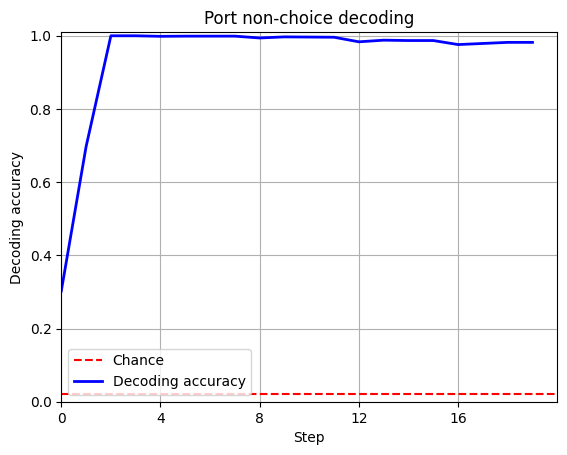

In [23]:
plot_decoding_accuracy(accuracies_not_action, n_class=Conf.port_dim, title='Port non-choice decoding')

In [ ]:
n_p_bins = 50
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
accuracies_p_bins, conf_matrices_p_bins, chance_p_bins, data = train_decoders(hiddens, targets=bins, layouts=layouts, n_class=n_p_bins, exclude_batch_idxs=non_anomalous_idxs, T=40, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy(accuracies_p_bins, chance=chance_p_bins, n_class=n_p_bins, title='p(A) decoding')

In [ ]:
plot_conf_matrices(conf_matrices_p_bins, bins, n_p_bins, bin_edges, mask_type='all')

In [ ]:
n_p_bins = 4
bin_edges = np.array([0.2, 0.5, 0.8, 1.0]) #np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
accuracies_p_bins, conf_matrices_p_bins, chance, data = train_decoders(hiddens, targets=bins, layouts=layouts, n_class=n_p_bins, exclude_batch_idxs=non_anomalous_idxs, T=40, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy(accuracies_p_bins, chance=None, n_class=n_p_bins, title='p(A) decoding')

In [ ]:
plot_conf_matrices(conf_matrices_p_bins, bins, n_p_bins, bin_edges, mask_type='step')

In [ ]:
N_step = 40

hiddens_flatten = hiddens[:, :N_step, :].reshape(-1, 1, hiddens.shape[-1])
t_step = np.broadcast_to(np.arange(N_step), (hiddens.shape[0], N_step))
t_step_flatten = t_step.flatten()
layouts_flatten = np.repeat(layouts, hiddens_flatten.shape[0] // hiddens.shape[0], axis=0)
print(hiddens_flatten.shape)
print(t_step_flatten.shape)
print(layouts_flatten.shape)

accuracies_t_step, conf_matrices_t_step, chance, _ = train_decoders(hiddens_flatten, targets=t_step_flatten, layouts=layouts_flatten, T=40, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy(accuracies_p_good, n_class=2, title='p(A) decoding')

## Cross-step decoding

In [7]:
train_steps = np.arange(160)

In [43]:
a = np.arange(9).reshape(3,3)
print(a)
np.random.shuffle(a)
print(a)


[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [93]:
train_steps = range(156,160)
scale = False
accs, conf_mats = train_decoders_looped(hiddens, action, layouts, train_steps=train_steps, T=40, fold_trials=True, scale=scale, 
                                        shuffle=True, exclude_batch_idxs=anomalous_idxs, multi_class='ovr', max_iter=1000)

9815 185
(7852, 160, 512) (1963, 160, 512) (7852, 160) (1963, 160) (7852, 2) (1963, 2)
(7852, 4, 512) (7852, 4)
(7852, 4, 512) (7852, 4)


100%|██████████| 40/40 [00:00<00:00, 132.74it/s]


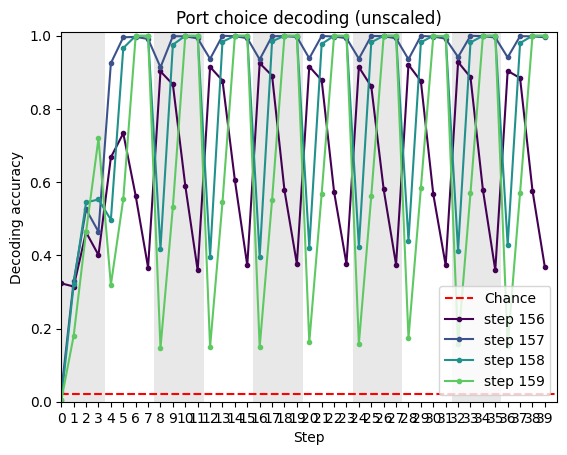

In [94]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=40, title='Port choice decoding ({})'.format('scaled' if scale else 'unscaled'))

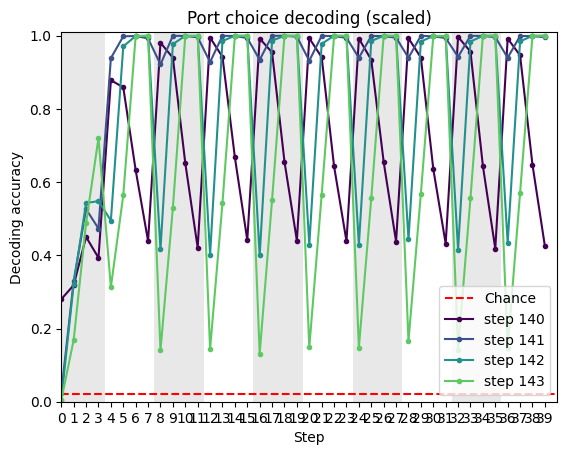

In [65]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=40, title='Port choice decoding (scaled)')

In [80]:
accs, conf_mats = train_decoders_looped(hiddens, action, layouts, train_steps=train_steps, T=40, fold_trials=True, scale=True, 
                                        exclude_batch_idxs=anomalous_idxs, multi_class='ovr', max_iter=1000, random_state=42)

9815 185
(7852, 160, 512) (1963, 160, 512) (7852, 160) (1963, 160) (7852, 2) (1963, 2)
(7852, 156, 512) (7852, 156)
(306228, 4, 512) (306228, 4)


100%|██████████| 40/40 [00:00<00:00, 90.41it/s]


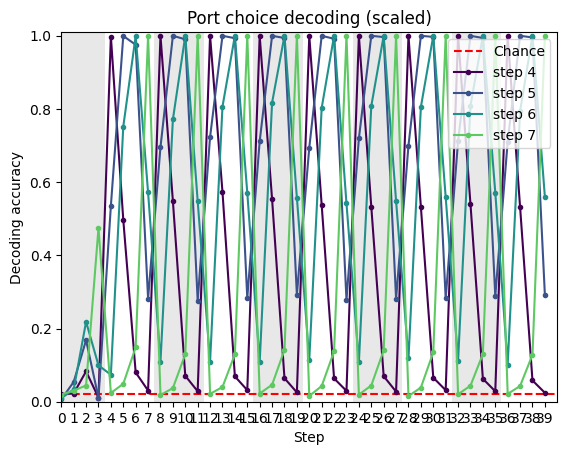

In [81]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=40, title='Port choice decoding (scaled)')

In [88]:
train_steps = range(152,160)
accs, conf_mats = train_decoders_looped(hiddens, action, layouts, train_steps=train_steps, T=40, fold_trials=True, scale=True, 
                                        exclude_batch_idxs=anomalous_idxs, multi_class='ovr', max_iter=1000, random_state=42)

9815 185
(7852, 160, 512) (1963, 160, 512) (7852, 160) (1963, 160) (7852, 2) (1963, 2)
(7852, 8, 512) (7852, 8)
(15704, 4, 512) (15704, 4)


100%|██████████| 40/40 [00:00<00:00, 77.68it/s]


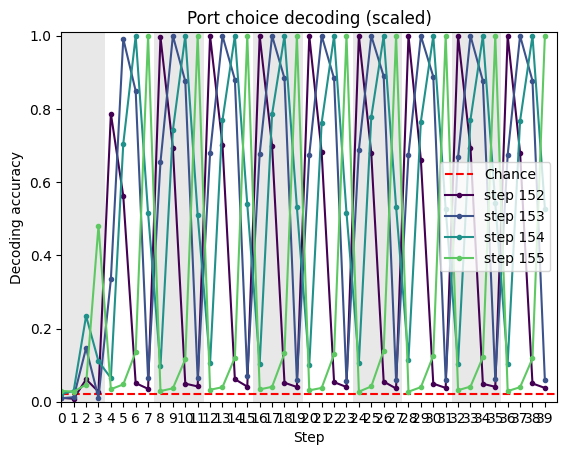

In [89]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=40, title='Port choice decoding (scaled)')

In [19]:
accs, conf_mats = train_decoders_looped(hiddens, action, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=True, exclude_batch_idxs=non_anomalous_idxs, multi_class='ovr', max_iter=1000, random_state=42)

185 9815
(148, 160, 512) (37, 160, 512) (148, 160) (37, 160) (148, 2) (37, 2)
(148, 160, 512) (148, 160)
(5920, 4, 512) (5920, 4)


100%|██████████| 160/160 [00:00<00:00, 1132.15it/s]


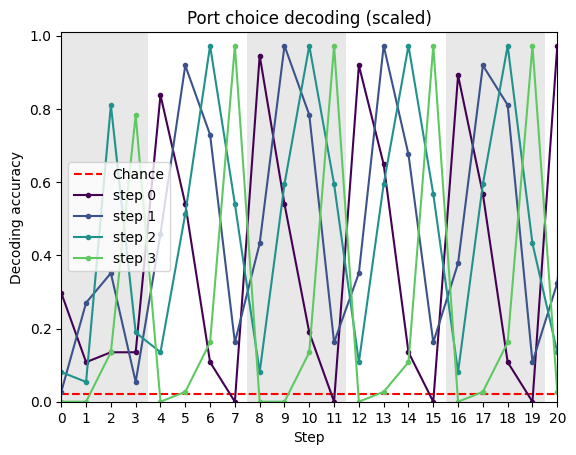

In [20]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=20, title='Port choice decoding (scaled)')
fig = plt.gcf()
fig.savefig('./figs/choice_scaled_.png', dpi=300)

In [21]:
accs, conf_mats = train_decoders_looped(hiddens, action, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=False, 
                                        exclude_batch_idxs=non_anomalous_idxs, multi_class='ovr', max_iter=500, random_state=42)

185 9815
(148, 160, 512) (37, 160, 512) (148, 160) (37, 160) (148, 2) (37, 2)
(148, 160, 512) (148, 160)
(5920, 4, 512) (5920, 4)


100%|██████████| 160/160 [00:00<00:00, 745.68it/s]


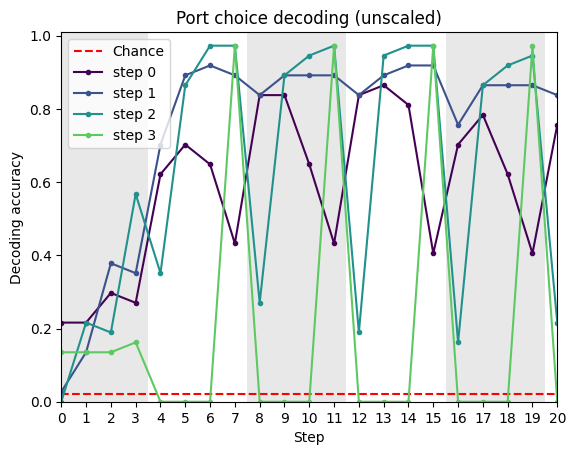

In [22]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=20, title='Port choice decoding (unscaled)')
fig = plt.gcf()
fig.savefig('./figs/choice_unscaled_.png', dpi=300)

In [15]:
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=True,
                                        exclude_batch_idxs=non_anomalous_idxs, multi_class='ovr', max_iter=500, random_state=42)

5043 4957
(4034, 160, 512) (1009, 160, 512) (4034, 160) (1009, 160) (4034, 2) (1009, 2)
(4034, 160, 512) (4034, 160)
(161360, 4, 512) (161360, 4)


  0%|          | 0/4 [00:00<?, ?it/s]/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 160/160 [00:00<00:00, 212.32it/s]


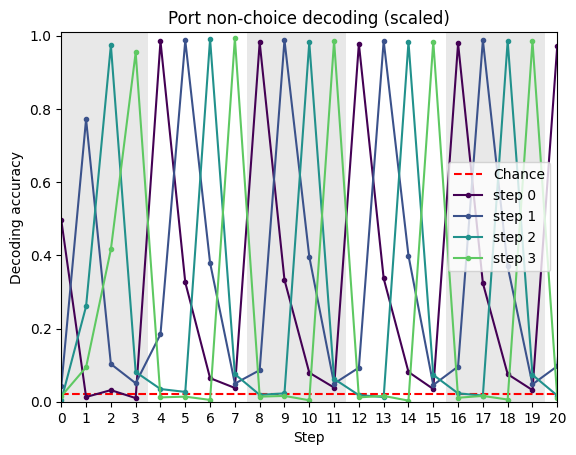

In [17]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=20, title='Port non-choice decoding (scaled)')
fig = plt.gcf()
fig.savefig('./figs/nonchoice_scaled.png', dpi=300)

In [13]:
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=False, 
                                        exclude_batch_idxs=non_anomalous_idxs, multi_class='ovr', max_iter=1000, random_state=42)

5043 4957
(4034, 160, 512) (1009, 160, 512) (4034, 160) (1009, 160) (4034, 2) (1009, 2)
(4034, 160, 512) (4034, 160)
(161360, 4, 512) (161360, 4)


100%|██████████| 160/160 [00:00<00:00, 342.15it/s]


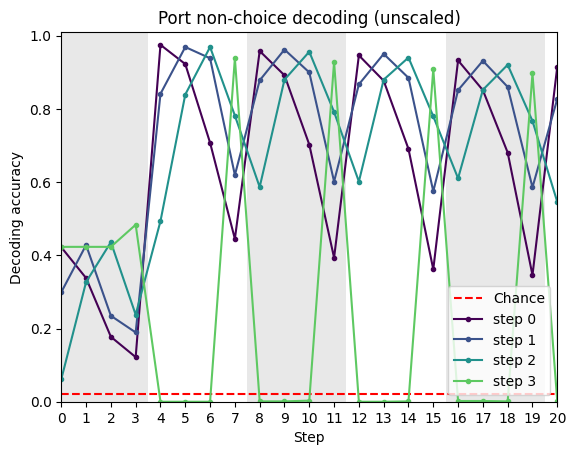

In [14]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=20, title='Port non-choice decoding (unscaled)')
fig = plt.gcf()
fig.savefig('./figs/nonchoice_unscaled.png', dpi=300)

In [35]:
n_p_bins = 4
bin_edges = np.array([0.2, 0.5, 0.8, 1.0]) #np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
# bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.digitize(np.abs(p_A-0.5)+0.5, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
train_steps = np.arange(160)
accs, conf_mats = train_decoders_looped(hiddens, bins, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=True, 
                                        exclude_batch_idxs=non_anomalous_idxs, multi_class='ovr', max_iter=1000, random_state=42)

5043 4957
(4034, 160, 512) (1009, 160, 512) (4034, 160) (1009, 160) (4034, 2) (1009, 2)
(4034, 160, 512) (4034, 160)
(161360, 4, 512) (161360, 4)


100%|██████████| 160/160 [00:00<00:00, 253.24it/s]


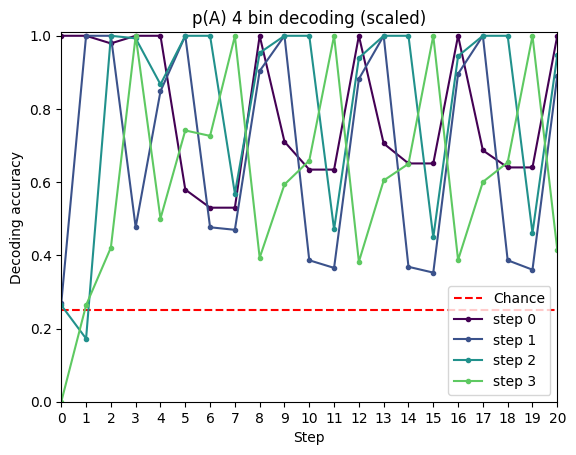

In [36]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=n_p_bins, T=20, title='p(A) 4 bin decoding (scaled)')

In [37]:
accs, conf_mats = train_decoders_looped(hiddens, bins, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=False, 
                                        exclude_batch_idxs=non_anomalous_idxs, multi_class='ovr', max_iter=1000, random_state=42)

5043 4957
(4034, 160, 512) (1009, 160, 512) (4034, 160) (1009, 160) (4034, 2) (1009, 2)
(4034, 160, 512) (4034, 160)
(161360, 4, 512) (161360, 4)


100%|██████████| 160/160 [00:00<00:00, 480.56it/s]


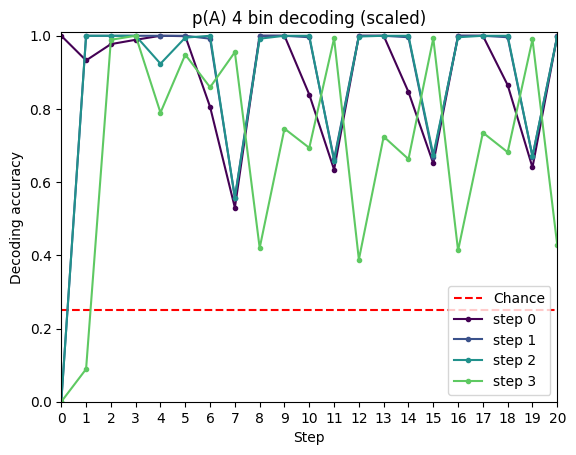

In [38]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=n_p_bins, T=20, title='p(A) 4 bin decoding (scaled)')

In [8]:
n_p_bins = 10
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
train_steps = np.arange(160)
accs, conf_matrices = train_decoders_looped(hiddens, bins, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=True,
                                            exclude_batch_idxs=non_anomalous_idxs, multi_class='ovr', max_iter=1000, random_state=42)

5043 4957
(4034, 160, 512) (1009, 160, 512) (4034, 160) (1009, 160) (4034, 2) (1009, 2)
(4034, 160, 512) (4034, 160)
(161360, 4, 512) (161360, 4)


100%|██████████| 160/160 [00:00<00:00, 222.39it/s]


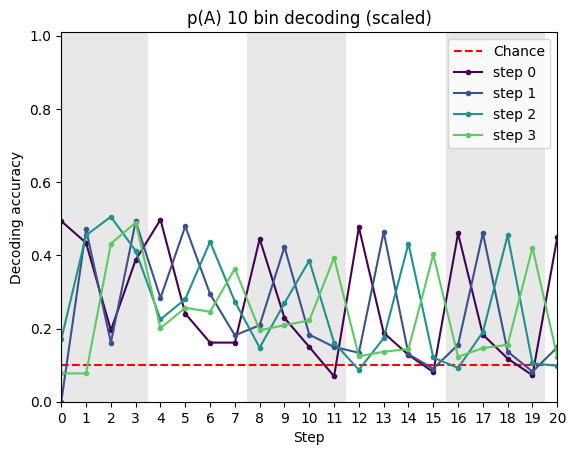

In [9]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=n_p_bins, T=20, title=f'p(A) {n_p_bins} bin decoding (scaled)')
fig = plt.gcf()
fig.savefig('./figs/probs_scaled.png', dpi=300)

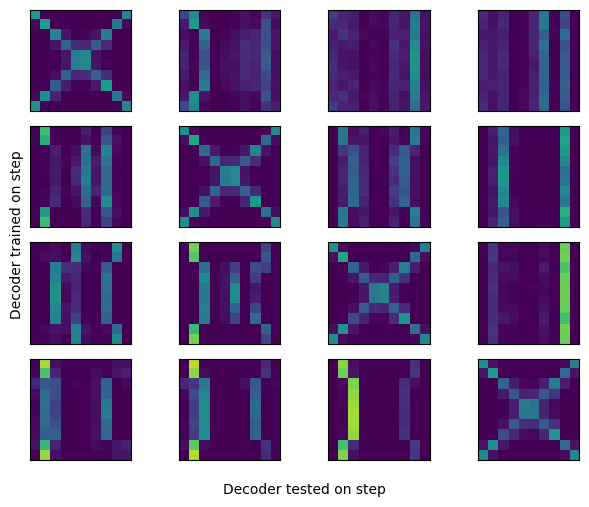

In [10]:
plot_conf_matrices_by_step(conf_matrices)
fig = plt.gcf()
fig.savefig(f'./figs/cm_probs_scaled')

In [11]:
n_p_bins = 10
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
train_steps = np.arange(160)
accs, conf_matrices = train_decoders_looped(hiddens, bins, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=False,
                                            exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)

(8000, 160, 512) (2000, 160, 512) (8000, 160) (2000, 160) (8000, 2) (2000, 2)
(8000, 160, 512) (8000, 160)
(320000, 4, 512) (320000, 4)


100%|██████████| 160/160 [00:00<00:00, 243.15it/s]


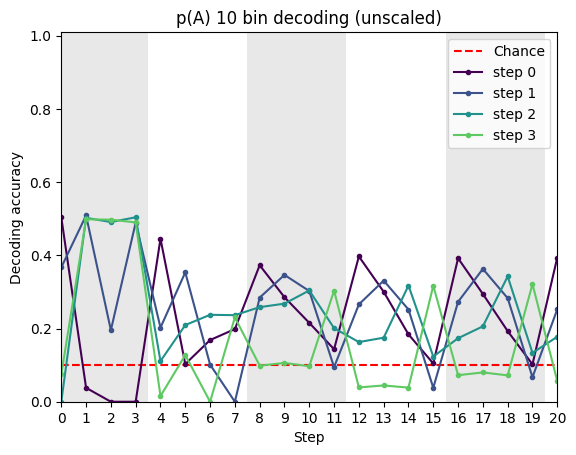

In [12]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=n_p_bins, T=20, title=f'p(A) {n_p_bins} bin decoding (unscaled)')
fig = plt.gcf()
fig.savefig('./figs/probs_unscaled.png', dpi=300)

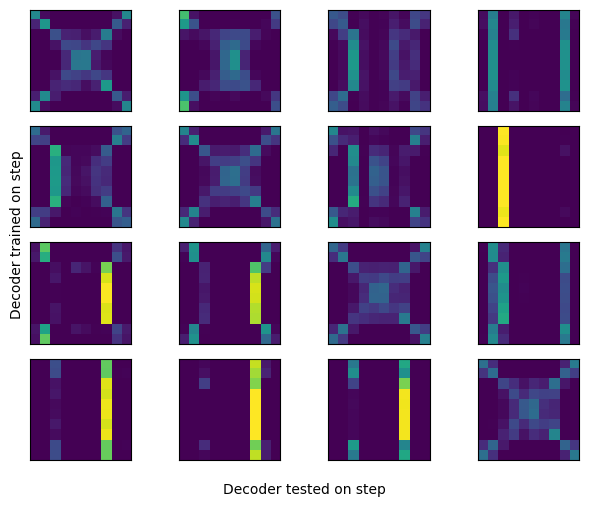

In [13]:
plot_conf_matrices_by_step(conf_matrices)
fig = plt.gcf()
fig.savefig('./figs/cm_probs_unscaled.png')

(36, 36)


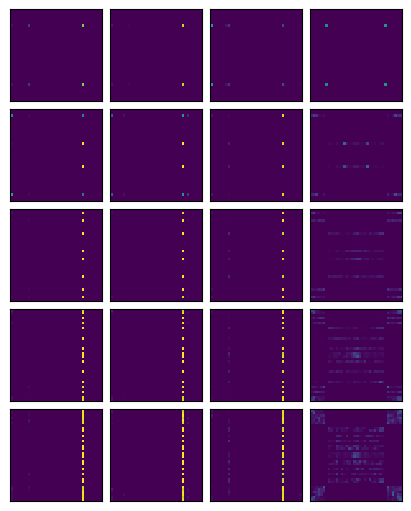

In [103]:
# m = conf_matrices[3]
# print(m[1].shape)

# k=20
# fig, axes = plt.subplots(k // Conf.trial_len, Conf.trial_len, figsize=(4, k//Conf.trial_len), layout='constrained')
# axes = axes.flatten()

# for i in range(k):
#     ax = axes[i]
#     mat = normalise(m[i])
#     ax.imshow(mat, vmin=0, vmax=1, cmap='viridis', interpolation='none')
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
#     # ax.set_title(f'step {i}')
#     # ax.set_aspect('auto')

40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40


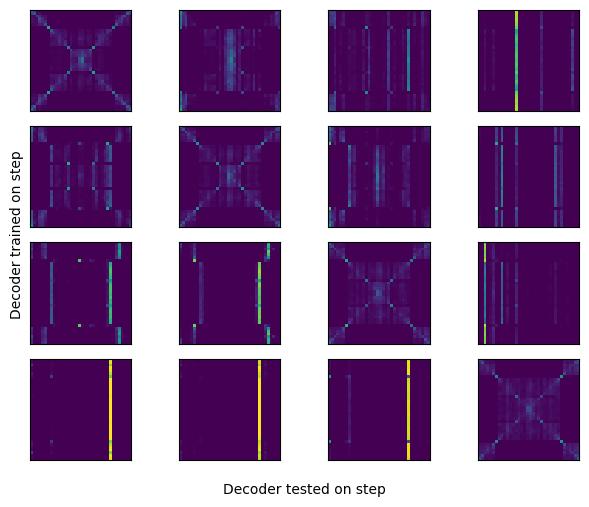

In [102]:
fig, axes = plt.subplots(Conf.trial_len, Conf.trial_len)

for row, m in enumerate(conf_matrices):
    for col in range(Conf.trial_len):
        ax = axes[row, col]
        mats = m[col::Conf.trial_len]
        # Assuming you have a list of arrays called 'arr_list'
        mat = np.sum(mats, axis=0)
        mat = normalise(mat)
        ax.imshow(mat, vmin=0, vmax=1, cmap='viridis', interpolation='none')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# Add major x label to the side of the figure
fig.text(0.5, -0.04, 'Decoder tested on step', ha='center')
# Add major y label to the side of the figure
fig.text(0.04, 0.5, 'Decoder trained on step', va='center', rotation='vertical')
fig.tight_layout()



In [149]:
n_p_bins = 20
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
# action_p_bins = n_p_bins * action + bins
action_p_bins = Conf.port_dim * bins + action
train_steps = np.arange(156,160)
accs, conf_matrices = train_decoders_looped(hiddens, action_p_bins, layouts, train_steps=train_steps, T=160, fold_trials=True, 
                                            exclude_batch_idxs=None, n_class = n_p_bins * Conf.port_dim,
                                            multi_class='ovr', max_iter=1000, random_state=42)

(8000, 160, 512) (2000, 160, 512) (8000, 160) (2000, 160) (8000, 2) (2000, 2)
(8000, 4, 512) (8000, 4)
(8000, 4, 512) (8000, 4)


100%|██████████| 160/160 [00:02<00:00, 58.32it/s]


In [13]:
plt.figure()
# Define the colormap
cmap = plt.cm.get_cmap('viridis')

# k=(np.array(train_steps[:Conf.trial_len])%Conf.trial_len)
for i, (acc, train_step) in enumerate(zip(accs, train_steps)):
    # Calculate the color based on the index
    color = cmap(i / len(accs))
    plt.plot(acc, label=f'step {train_step}', color=color, marker='o', markersize=3)

plt.xticks(np.arange(len(accs[0])))
plt.xlim(left=0, right=80)
plt.legend()

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_8693/2620116466.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [151]:
conf_matrices[0][0].shape

(1000, 1000)

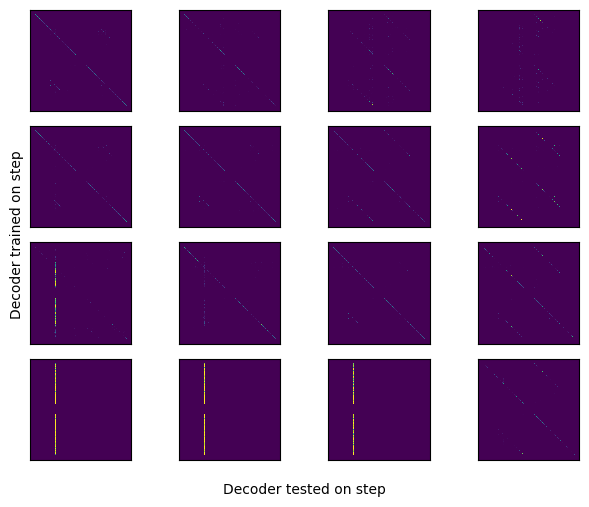

In [152]:
plot_conf_matrices_by_step(conf_matrices)

In [17]:
# n_p_bins = 50
# bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
# bins = np.digitize(p_A, bin_edges).squeeze()
# bins = np.repeat(bins, Conf.trial_len, axis=-1)
train_steps = np.arange(4)
bins = np.repeat(p_A.squeeze(), Conf.trial_len, axis=-1)
accs, conf_matrices, data = train_decoders_looped(hiddens, bins, layouts, train_steps=train_steps, T=160, fold_trials=True, exclude_batch_idxs=None)

(8000, 160, 512) (2000, 160, 512) (8000, 160) (2000, 160) (8000, 2) (2000, 2)
(8000, 4, 512) (8000, 4)
(8000, 4, 512) (8000, 4)


100%|██████████| 160/160 [00:00<00:00, 1098.73it/s]


In [30]:
y_preds, y_true = data

y_preds = np.array(y_preds)
y_true = np.array(y_true)

y_preds.shape

y_preds[3, :, 0]
# y_true[0, :, 0]

array([ 9.781698  ,  0.6302378 ,  5.0526776 ,  0.6032552 , -2.4401958 ,
       -1.7860384 ,  1.5382974 , -1.1986833 ,  2.809179  ,  3.1151972 ,
        4.0032473 , -1.3966053 ,  2.7823918 ,  2.4644914 ,  3.9924853 ,
       -1.4170635 ,  6.7551317 ,  5.0447984 ,  4.7930856 , -0.53746754,
       -0.18729168, -0.11544418,  0.7351469 , -0.09365541, -0.47372717,
        0.1091156 ,  2.1025527 , -0.32187384,  3.7595484 , -0.20210797,
        1.8849902 , -1.4037921 ,  5.921484  ,  5.2563543 ,  5.071837  ,
       -0.8428059 ,  2.9681644 , -0.62929946,  1.0066833 , -1.759706  ,
        5.977034  ,  4.2653465 ,  3.7527401 , -0.2864197 ,  3.2861114 ,
       -0.28735334,  0.9247132 , -1.3493774 ,  0.94937414,  1.4176106 ,
        3.6565483 , -1.4108069 ,  2.834812  ,  2.108534  ,  3.814997  ,
       -1.0708005 ,  2.1424396 ,  2.5312736 ,  4.514674  , -1.2859983 ,
        2.994544  ,  2.840984  ,  4.4797897 , -1.2636402 ,  2.7187254 ,
        2.6609638 ,  4.4410405 , -1.3057511 ,  2.8294263 ,  2.70

## Cross port decoding

In [65]:
port_id = 1

In [101]:
from functions import *
n_p_bins = 10
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins

p_A_ = np.abs(p_A-0.5)+0.5
bins = np.digitize(p_A_, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
train_steps = np.arange(4,160)

accs_all = []
for port_id in range(20):
    accs, conf_matrices = train_decoders_looped_port(port_id, hiddens, bins, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=False,
                                                exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)
    accs_all.append(accs)

(373, 160, 512) (19627, 160, 512) (373, 160) (19627, 160) (373, 2) (19627, 2)
(373, 156, 512) (373, 156)
(14547, 4, 512) (14547, 4)


100%|██████████| 160/160 [00:07<00:00, 21.38it/s]


(377, 160, 512) (19623, 160, 512) (377, 160) (19623, 160) (377, 2) (19623, 2)
(377, 156, 512) (377, 156)
(14703, 4, 512) (14703, 4)


 49%|████▉     | 78/160 [00:03<00:04, 20.44it/s]


KeyboardInterrupt: 

In [85]:
accs_all = np.array(accs_all)
print(accs_all.shape)
accs_mean = np.mean(accs_all, axis=0)

(20, 4, 160)


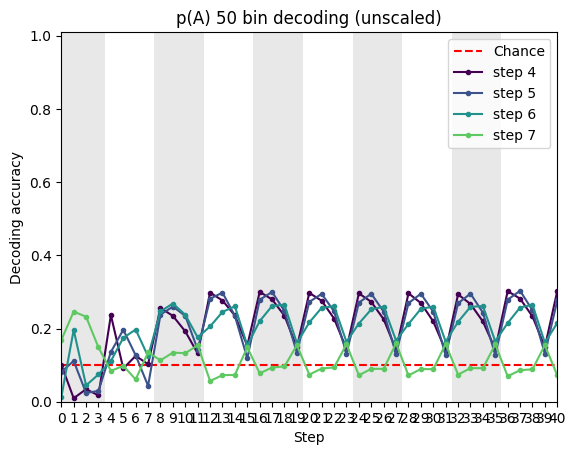

In [86]:
plot_decoding_accuracy_looped(accs_mean, train_steps, n_class=n_p_bins, T=40, title='p(A) 50 bin decoding (unscaled)')

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_2230/4072875913.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


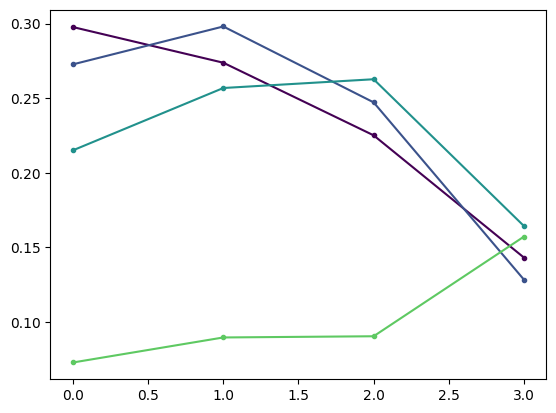

In [100]:
accs_means_fold = np.zeros((Conf.trial_len, Conf.trial_len))
for i in range(Conf.trial_len):
    x = np.mean(accs_mean[:,2*Conf.trial_len+i::Conf.trial_len], axis=(-1))
    accs_means_fold[:, i] = x

cmap = plt.cm.get_cmap('viridis')
for i, line in enumerate(accs_means_fold):
    color = cmap(i / len(accs))
    plt.plot(line, color=color, marker='o', markersize=3)

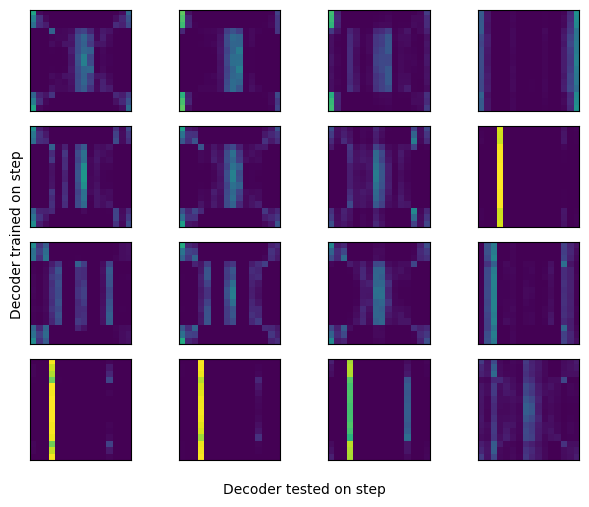

In [73]:
plot_conf_matrices_by_step(conf_matrices)

## What are my hypotheses?

### Trivial ones
1. Both ports decodable at every timestep
2. p(A) decodable at every timestep

### Non-trivial ones
3. Choice represented as good/bad binary or value continuum
4. Value integration is stimulus-generic
5. Value integration is stimulus-specific
